# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Runge-Kutta-methods-for-ODE-integration-in-OCaml" data-toc-modified-id="Runge-Kutta-methods-for-ODE-integration-in-OCaml-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Runge-Kutta methods for ODE integration in OCaml</a></div><div class="lev2 toc-item"><a href="#Preliminary" data-toc-modified-id="Preliminary-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preliminary</a></div><div class="lev2 toc-item"><a href="#Runge-Kutta-method-of-order-1,-or-the-Euler-method" data-toc-modified-id="Runge-Kutta-method-of-order-1,-or-the-Euler-method-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Runge-Kutta method of order 1, or the Euler method</a></div><div class="lev2 toc-item"><a href="#Runge-Kutta-method-of-order-2" data-toc-modified-id="Runge-Kutta-method-of-order-2-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Runge-Kutta method of order 2</a></div><div class="lev2 toc-item"><a href="#Runge-Kutta-method-of-order-4,-&quot;RK4&quot;" data-toc-modified-id="Runge-Kutta-method-of-order-4,-&quot;RK4&quot;-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Runge-Kutta method of order 4, <em>"RK4"</em></a></div><div class="lev2 toc-item"><a href="#Comparisons" data-toc-modified-id="Comparisons-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Comparisons</a></div><div class="lev2 toc-item"><a href="#Conclusion" data-toc-modified-id="Conclusion-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Conclusion</a></div>

# Runge-Kutta methods for ODE integration in OCaml

- I want to implement and illustrate the [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (actually, different variants), in the [OCaml programming language](https://www.ocaml.org/).

- The Runge-Kutta methods are a family of numerical iterative algorithms to approximate solutions of [Ordinary Differential Equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation). I will simply implement them, for the mathematical descriptions, I let the interested reader refer to the Wikipedia page, or [any](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#References) [good](https://www.directtextbook.com/isbn/9780521007948) [book](https://www.decitre.fr/livres/analyse-numerique-et-equations-differentielles-9782868838919.html) or [course](https://courses.maths.ox.ac.uk/node/4294) on numerical integration of ODE.
- I will start with the order 1 method, then the order 2 and the most famous order 4.
- They will be compared on different ODE.

## Preliminary

In [1]:
Sys.command "ocaml -version";;

The OCaml toplevel, version 4.04.2


- : int = 0


In [147]:
#thread ;;
#require "jupyter.notebook" ;;
#require "jupyter.archimedes" ;;

I don't want to try to find a reference implementation of an Ordinary Differential Equations solver in OCaml. I'm sure there is, just don't care.

I will use as a first example the one included in [the scipy (Python) documentation for this `odeint` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html).

$$\theta''(t) + b \theta'(t) + c \sin(\theta(t)) = 0.$$

If $\omega(t) := \theta'(t)$, this gives
$$ \begin{cases}
\theta'(t) = \omega(t) \\
\omega'(t) = -b \omega(t) - c \sin(\theta(t))
\end{cases} $$

Vectorially, if $y(t) = [\theta(t), \omega(t)]$, then the equation is $y' = f(t, y)$ where $f(t, y) = [y_2(t), -b y_2(t) - c \sin(y_1(t))]$.

We assume the values of $b$ and $c$ to be known, and the starting point to be also fixed:

In [11]:
let b = 0.25 ;;
let c = 5.0 ;;

val b : float = 0.25


val c : float = 5.


In [14]:
let y0 = [| 3.14156 -. 0.1; 0.0 |];;

val y0 : float array = [|3.04156; 0.|]


In [148]:
let f_pend (y : float array) (_ : float) : float array =
    [|
        y.(1);
        (-.b) *. y.(1) +. (-.c) *. sin(y.(0))
    |]
;;

val f_pend : float array -> float -> float array = <fun>


----
## Runge-Kutta method of order 1, or the Euler method

The approximation is computed using this update:
$$y_{n+1} = y_n + (t_{n+1} - t_n) f(y_n, t_n).$$

The math behind this formula are the following: if $g$ is a solution to the ODE, and so far the approximation is correct, $y_n \simeq g(t_n)$, then a small step $h = t_{n+1} - t_n$ satisfy $g(t_n + h) \simeq g(t_n) + h g'(t_n) \simeq y_n + h f(g(t_n), t_n) + \simeq y_n + h f(y_n, t_n)$.

In [32]:
let rungekutta1 (f : float array -> float -> float array) (y0 : float array) (t : float array) =
    let d = Array.length y0 in
    let n = Array.length t in
    let y = Array.make_matrix n d 0. in
    for j   = 0 to d-1 do
        y.(0).(j) <- y0.(j);
    done;
    for i = 0 to n-2 do
        let h   = t.(i+1) -. t.(i) in
        let fyt = f y.(i) t.(i) in
        for j   = 0 to d-1 do
            y.(i+1).(j) <- y.(i).(j) +. h *. fyt.(j);
        done;
    done;
    y
;;

val rungekutta1 :
  (float array -> float -> float array) ->
  float array -> float array -> float array array = <fun>


We have to redefine ourselfves most of the useful functions:

In [28]:
let linspace (a : float) (b : float) (n : int) =
    let t = Array.make n a in
    let h = (b -. a) /. (float_of_int n) in
    for i = 0 to n-1 do
        t.(i) <- a +. (float_of_int i) *. h;
    done;
    t
;;

val linspace : float -> float -> int -> float array = <fun>


In [30]:
let t = linspace 0. 10. 101 ;;

val t : float array =
  [|0.; 0.0990099009900990146; 0.198019801980198029; 0.297029702970297071;
    0.396039603960396058; 0.495049504950495045; 0.594059405940594143;
    0.69306930693069313; 0.792079207920792117; 0.891089108910891103;
    0.99009900990099009; 1.08910891089108919; 1.18811881188118829;
    1.28712871287128716; 1.38613861386138626; 1.48514851485148514;
    1.58415841584158423; 1.68316831683168333; 1.78217821782178221;
    1.8811881188118813; 1.98019801980198018; 2.07920792079207928;
    2.17821782178217838; 2.27722772277227747; 2.37623762376237657;
    2.47524752475247523; 2.57425742574257432; 2.67326732673267342;
    2.77227722772277252; 2.87128712871287162; 2.97029702970297027;
    3.06930693069306937; 3.16831683168316847; 3.26732673267326756;
    3.36633663366336666; 3.46534653465346532; 3.56435643564356441;
    3.66336633663366351; 3.76237623762376261; 3.86138613861386171;
    3.96039603960396036; 4.05940594059405946; 4.15841584158415856;
    4.25742574257425765; 4.3

In [31]:
let sol = rungekutta1 f_pend y0 t ;;

val sol : float array array =
  [|[|3.04156; 0.|]; [|3.04156; -0.0494385678472543874|];
    [|3.03666509229235126; -0.097653408767596539|];
    [|3.02699643795892603; -0.147085318849099422|];
    [|3.01243353510257972; -0.200051306879579782|];
    [|2.99262647501549273; -0.258862071967601193|];
    [|2.96699656689988878; -0.325927783092890666|];
    [|2.93472648936593927; -0.403855500959909908|];
    [|2.89474079620159186; -0.495539222697703119|];
    [|2.84567750682558174; -0.604239966604331213|];
    [|2.78585176755782626; -0.73364756279708776|];
    [|2.71321339500365921; -0.887906266173617|];
    [|2.62530188350132088; -1.07157049578384078|];
    [|2.51920579480985163; -1.28943151630173158|];
    [|2.39153930804730397; -1.54611693249596316|];
    [|2.23845842364176306; -1.84531096455946542|];
    [|2.05575436774478604; -2.18838313254248|];
    [|1.83908277046335211; -2.57218281242493196|];
    [|1.5844112048767256; -2.98585479258093889|];
    [|1.28878201749247401; -3.4069511189918

In [34]:
let column sol i =
    Array.map (fun x -> x.(i)) sol
;;

val column : 'a array array -> int -> 'a array = <fun>


Let see a first plot!

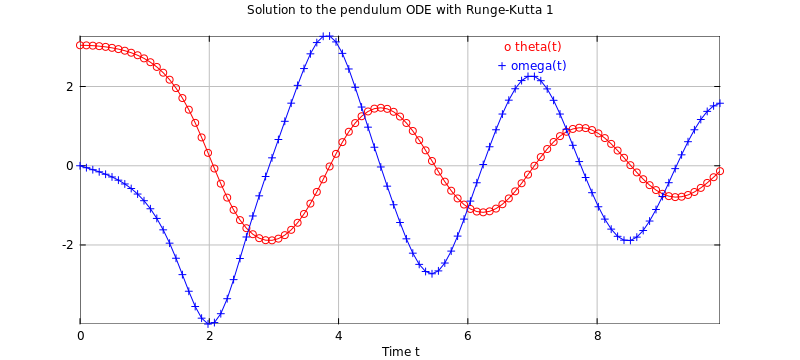

- : unit = ()


In [151]:
let vp = A.init ~w:800. ~h:360. ["jupyter"] in
A.Axes.box vp ;
A.Viewport.xlabel vp "Time t";
A.Viewport.title vp "Solution to the pendulum ODE with Runge-Kutta 1";
A.set_color vp A.Color.red ;
A.Viewport.text vp 7. 3. "o theta(t)" ;
A.Array.xy ~style:(`Linesmarkers "o") vp t (column sol 0);
A.set_color vp A.Color.blue ;
A.Viewport.text vp 7. 2.5 "+ omega(t)" ;
A.Array.xy ~style:(`Linesmarkers "+") vp t (column sol 1);
A.close vp;;

With the same number of points, the Euler method (*i.e.* the Runge-Kutta method of order 1) is less precise than the reference `solve` method. With more points, it can give a satisfactory approximation of the solution:

In [55]:
let t = linspace 0. 10. 1001 ;;
let sol = rungekutta1 f_pend y0 t ;;

val t : float array =
  [|0.; 0.00999000999000999; 0.01998001998001998; 0.0299700299700299683;
    0.03996003996003996; 0.0499500499500499517; 0.0599400599400599365;
    0.0699300699300699352; 0.07992007992007992; 0.0899100899100899;
    0.0999000999000999; 0.109890109890109888; 0.119880119880119873;
    0.129870129870129858; 0.13986013986013987; 0.149850149850149855;
    0.15984015984015984; 0.169830169830169825; 0.17982017982017981;
    0.189810189810189822; 0.199800199800199807; 0.209790209790209792;
    0.219780219780219777; 0.229770229770229761; 0.239760239760239746;
    0.249750249750249759; 0.259740259740259716; 0.269730269730269756;
    0.279720279720279741; 0.289710289710289726; 0.29970029970029971;
    0.309690309690309695; 0.31968031968031968; 0.329670329670329665;
    0.33966033966033965; 0.349650349650349634; 0.359640359640359619;
    0.369630369630369604; 0.379620379620379644; 0.389610389610389629;
    0.399600399600399614; 0.409590409590409599; 0.419580419580419584;
    

val sol : float array array =
  [|[|3.04156; 0.|]; [|3.04156; -0.00498830704552716622|];
    [|3.04151016676278196; -0.00996415578174981824|];
    [|3.04141062474698032; -0.0149300540462087225|];
    [|3.04126147335790709; -0.0198884971903821491|];
    [|3.04106278707228883; -0.0248419693190828489|];
    [|3.04081461555061949; -0.0297929445205624109|];
    [|3.04051698373722745; -0.0347438880877792081|];
    [|3.04016989194813858; -0.0396972577312808828|];
    [|3.0397733159468272; -0.0446555047841474054|];
    [|3.03932720700792469; -0.0496210753994339171|];
    [|3.03883149196896918; -0.0545964117405467325|];
    [|3.03828607327026257; -0.059583953164978172|];
    [|3.0376908289829; -0.0645861374018181639|];
    [|3.0370456128250396; -0.0696054017234524758|];
    [|3.03635025416646354; -0.0746441841118481442|];
    [|3.03560455802149; -0.0797049244198173|];
    [|3.0348083050302832; -0.0847900655276403459|];
    [|3.03396125142860829; -0.0899020544954184653|];
    [|3.033063129006076

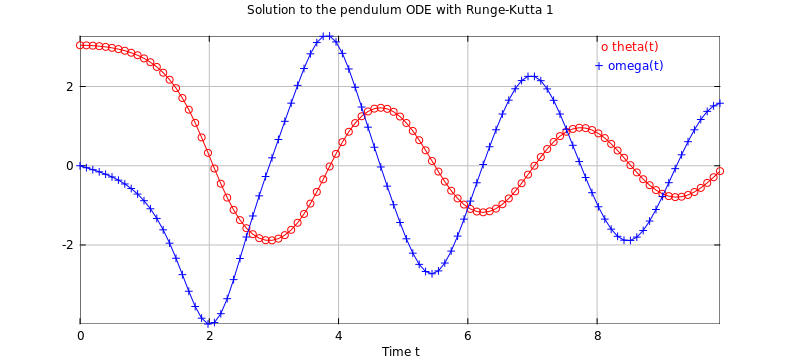

- : unit = ()


In [153]:
let vp = A.init ~w:800. ~h:360. ["jupyter"] in
A.Axes.box vp ;
A.Viewport.xlabel vp "Time t";
A.Viewport.title vp "Solution to the pendulum ODE with Runge-Kutta 1";
A.set_color vp A.Color.red ;
A.Viewport.text vp 8.5 3. "o theta(t)" ;
A.Array.xy ~style:(`Linesmarkers "o") vp t (column sol 0);
A.set_color vp A.Color.blue ;
A.Viewport.text vp 8.5 2.5 "+ omega(t)" ;
A.Array.xy vp ~style:(`Linesmarkers "+") t (column sol 1);
A.close vp;;

In [72]:
let t = linspace 0. 10. 10001 ;;
let sol = rungekutta1 f_pend y0 t ;;

val t : float array =
  [|0.; 0.000999900009999; 0.001999800019998; 0.00299970002999700022;
    0.003999600039996; 0.004999500049995; 0.00599940005999400044;
    0.00699930006999300094; 0.007999200079992; 0.008999100089991;
    0.00999900009999; 0.0109989001099890012; 0.0119988001199880009;
    0.012998700129987; 0.0139986001399860019; 0.0149985001499850015;
    0.015998400159984; 0.016998300169983; 0.017998200179982;
    0.018998100189981; 0.01999800019998; 0.0209979002099790028;
    0.0219978002199780025; 0.0229977002299770021; 0.0239976002399760018;
    0.024997500249975; 0.025997400259974; 0.026997300269973;
    0.0279972002799720038; 0.0289971002899710034; 0.0299970002999700031;
    0.0309969003099690027; 0.031996800319968; 0.032996700329967;
    0.033996600339966; 0.034996500349965; 0.035996400359964;
    0.036996300369963; 0.037996200379962; 0.038996100389961;
    0.03999600039996; 0.040995900409959006; 0.0419958004199580057;
    0.0429957004299570053; 0.0439956004399560049; 0.0

val sol : float array array =
  [|[|3.04156; 0.|]; [|3.04156; -0.000499279607296539596|];
    [|3.04155950077031578; -0.000998434407171997374|];
    [|3.04155850243574211; -0.00149746691424664175|];
    [|3.04155700511855942; -0.00199637964189098346|];
    [|3.04155500893853548; -0.00249517510223822188|];
    [|3.04155251401292581; -0.00299385580619668289|];
    [|3.04154952045647509; -0.00349242426346224686|];
    [|3.0415460283814193; -0.00399088298253077144|];
    [|3.04154203789748534; -0.0044892344707105|];
    [|3.04153754911189322; -0.00498748123413446723|];
    [|3.04153256212935741; -0.00548562577777289128|];
    [|3.04152707705208725; -0.00598367060544555563|];
    [|3.0415210939797892; -0.00648161821983419227|];
    [|3.04151461300966641; -0.00697947112249484164|];
    [|3.04150763423642134; -0.00747723181387021513|];
    [|3.0415001577522558; -0.00797490279330204457|];
    [|3.04149218364687313; -0.00847248655904342569|];
    [|3.0414837120074778; -0.00896998560827114676|];

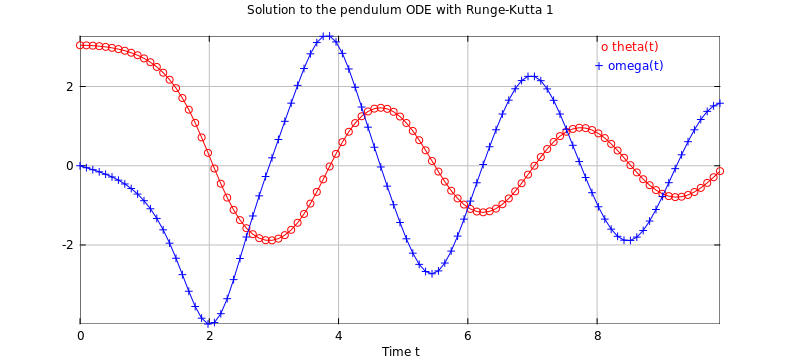

- : unit = ()


In [154]:
let vp = A.init ~w:800. ~h:360. ["jupyter"] in
A.Axes.box vp ;
A.Viewport.xlabel vp "Time t";
A.Viewport.title vp "Solution to the pendulum ODE with Runge-Kutta 1";
A.set_color vp A.Color.red ;
A.Viewport.text vp 8.5 3. "o theta(t)" ;
A.Array.xy ~style:(`Linesmarkers "o") vp t (column sol 0);
A.set_color vp A.Color.blue ;
A.Viewport.text vp 8.5 2.5 "+ omega(t)" ;
A.Array.xy vp ~style:(`Linesmarkers "+") t (column sol 1);
A.close vp;;

----
## Runge-Kutta method of order 2

The order 2 Runge-Method uses this update:
$$ y_{n+1} = y_n + h f(t + \frac{h}{2}, y_n + \frac{h}{2} f(t, y_n)),$$
if $h = t_{n+1} - t_n$.

Again, we need some basic functions as OCaml `Array` are quite poor.
With Julia arrays or NumPy Python arrays, we can write `h * f(y, t)` to multiply each entry of `f(y, t)` by a number h.

In [92]:
let aplus a k =
    Array.map ( ( +. ) k) a
;;

let ( ++. ) = aplus ;;

val aplus : float array -> float -> float array = <fun>


val ( ++. ) : float array -> float -> float array = <fun>


In [93]:
let aaplus a b =
    Array.map2 ( +. ) a b
;;

let ( +++. ) = aaplus ;;

val aaplus : float array -> float array -> float array = <fun>


val ( +++. ) : float array -> float array -> float array = <fun>


In [94]:
let amul a k =
    Array.map ( ( *. ) k ) a
;;

let ( **. ) = amul ;;

val amul : float array -> float -> float array = <fun>


val ( **. ) : float array -> float -> float array = <fun>


In [95]:
let rungekutta2 (f : float array -> float -> float array) (y0 : float array) (t : float array) =
    let d = Array.length y0 in
    let n = Array.length t in
    let y = Array.make_matrix n d 0. in
    for j = 0 to d-1 do
        y.(0).(j) <- y0.(j);
    done;
    for i = 0 to n-2 do
        let h    = t.(i+1) -. t.(i) in
        let fyt  = f y.(i) t.(i) in
        let fyt2 = f (y.(i) +++. (fyt **. (h /. 2.))) (t.(i) +. (h /. 2.)) in
        for j    = 0 to d-1 do
            y.(i+1).(j) <- y.(i).(j) +. h *. fyt2.(j);
        done;
    done;
    y
;;

val rungekutta2 :
  (float array -> float -> float array) ->
  float array -> float array -> float array array = <fun>


For our simple ODE example, this method is already quite efficient.

In [87]:
let t = linspace 0. 10. 101 ;;
let sol = rungekutta2 f_pend y0 t ;;

val t : float array =
  [|0.; 0.0990099009900990146; 0.198019801980198029; 0.297029702970297071;
    0.396039603960396058; 0.495049504950495045; 0.594059405940594143;
    0.69306930693069313; 0.792079207920792117; 0.891089108910891103;
    0.99009900990099009; 1.08910891089108919; 1.18811881188118829;
    1.28712871287128716; 1.38613861386138626; 1.48514851485148514;
    1.58415841584158423; 1.68316831683168333; 1.78217821782178221;
    1.8811881188118813; 1.98019801980198018; 2.07920792079207928;
    2.17821782178217838; 2.27722772277227747; 2.37623762376237657;
    2.47524752475247523; 2.57425742574257432; 2.67326732673267342;
    2.77227722772277252; 2.87128712871287162; 2.97029702970297027;
    3.06930693069306937; 3.16831683168316847; 3.26732673267326756;
    3.36633663366336666; 3.46534653465346532; 3.56435643564356441;
    3.66336633663366351; 3.76237623762376261; 3.86138613861386171;
    3.96039603960396036; 4.05940594059405946; 4.15841584158415856;
    4.25742574257425765; 4.3

val sol : float array array =
  [|[|3.04156; 0.|]; [|3.03911254614617565; -0.0488267043837982695|];
    [|3.03183092241293961; -0.0988404593793910102|];
    [|3.01948127772376; -0.152388585215509798|];
    [|3.00159483065725174; -0.211923116134953959|];
    [|2.97745224188518653; -0.280106126962090252|];
    [|2.9460575795158439; -0.359915119550046958|];
    [|2.90610187009085497; -0.454746846467090182|];
    [|2.85591658999954312; -0.568512488459194332|];
    [|2.79341852588212358; -0.705707056702320923|];
    [|2.71604980667654772; -0.871417812472915942|];
    [|2.62072159504783; -1.07120512144372437|];
    [|2.50377854277070533; -1.31073777557490101|];
    [|2.3610159594913549; -1.59498872770536404|];
    [|2.18780513934095255; -1.92670587301033902|];
    [|1.97941455921401221; -2.30382082261406795|];
    [|1.73164679588694903; -2.71560548610054786|];
    [|1.44191154148313938; -3.13804848237782785|];
    [|1.11075480950422323; -3.53044584205407341|];
    [|0.743572352514064394; -3.

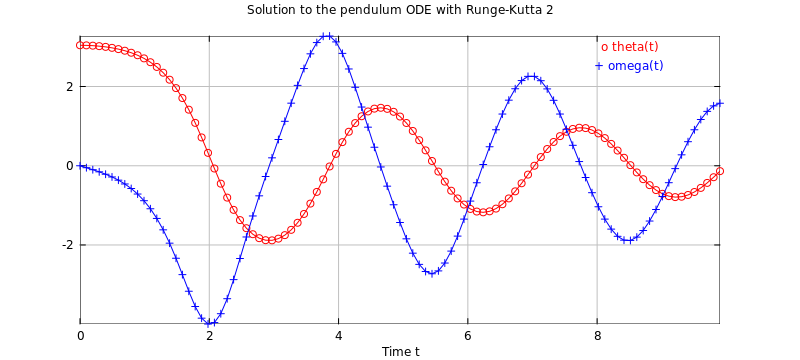

- : unit = ()


In [156]:
let vp = A.init ~w:800. ~h:360. ["jupyter"] in
A.Axes.box vp ;
A.Viewport.xlabel vp "Time t";
A.Viewport.title vp "Solution to the pendulum ODE with Runge-Kutta 2";
A.set_color vp A.Color.red ;
A.Viewport.text vp 8.5 3. "o theta(t)" ;
A.Array.xy ~style:(`Linesmarkers "o") vp t (column sol 0);
A.set_color vp A.Color.blue ;
A.Viewport.text vp 8.5 2.5 "+ omega(t)" ;
A.Array.xy vp ~style:(`Linesmarkers "+") t (column sol 1);
A.close vp;;

----
## Runge-Kutta method of order 4, *"RK4"*

The order 4 Runge-Method uses this update:
$$ y_{n+1} = y_n + \frac{h}{6} (k_1 + 2 k_2 + 2 k_3 + k_4),$$
if $h = t_{n+1} - t_n$, and
$$\begin{cases}
k_1 &= f(y_n, t_n), \\
k_2 &= f(y_n + \frac{h}{2} k_1, t_n + \frac{h}{2}), \\
k_3 &= f(y_n + \frac{h}{2} k_2, t_n + \frac{h}{2}), \\
k_4 &= f(y_n + h k_3, t_n + h).
\end{cases}$$

In [97]:
let rungekutta4 (f : float array -> float -> float array) (y0 : float array) (t : float array) =
    let d = Array.length y0 in
    let n = Array.length t in
    let y = Array.make_matrix n d 0. in
    for j = 0 to d-1 do
        y.(0).(j) <- y0.(j);
    done;
    for i = 0 to n-2 do
        let h  = t.(i+1) -. t.(i) in
        let k1 = f y.(i) t.(i) in
        let k2 = f (y.(i) +++. (k1 **. (h /. 2.))) (t.(i) +. (h /. 2.)) in
        let k3 = f (y.(i) +++. (k2 **. (h /. 2.))) (t.(i) +. (h /. 2.)) in
        let k4 = f (y.(i) +++. (k3 **. h)) (t.(i) +. h) in
        for j  = 0 to d-1 do
            y.(i+1).(j) <- y.(i).(j) +. (h/.6.) *. (k1.(j) +. 2.*.k2.(j) +. 2.*.k3.(j) +. k4.(j));
        done;
    done;
    y
;;

val rungekutta4 :
  (float array -> float -> float array) ->
  float array -> float array -> float array array = <fun>


For our simple ODE example, this method is even more efficient.

In [107]:
let t = linspace 0. 10. 31 ;;
let sol = rungekutta4 f_pend y0 t ;;

val t : float array =
  [|0.; 0.322580645161290314; 0.645161290322580627; 0.967741935483871;
    1.29032258064516125; 1.61290322580645151; 1.93548387096774199;
    2.25806451612903203; 2.58064516129032251; 2.90322580645161299;
    3.22580645161290303; 3.54838709677419351; 3.87096774193548399;
    4.19354838709677402; 4.51612903225806406; 4.83870967741935498;
    5.16129032258064502; 5.48387096774193505; 5.80645161290322598;
    6.12903225806451601; 6.45161290322580605; 6.77419354838709697;
    7.09677419354838701; 7.41935483870967705; 7.74193548387096797;
    8.06451612903225801; 8.38709677419354804; 8.70967741935483808;
    9.03225806451612812; 9.35483870967742; 9.67741935483871|]


val sol : float array array =
  [|[|3.04156; 0.|]; [|3.01514459001706; -0.168073982292008067|];
    [|2.92524068186212505; -0.40997602608111805|];
    [|2.73082595162226482; -0.83986111238677208|];
    [|2.34558387188495843; -1.62374367239927175|];
    [|1.63147992840831235; -2.86279243145111817|];
    [|0.508849624613306517; -3.94638176996873646|];
    [|-0.729938057166801491; -3.4423574128899137|];
    [|-1.58130089343988933; -1.76934614226155151|];
    [|-1.88100723824819749; -0.124998397630503355|];
    [|-1.67675988248597196; 1.38189318693121943|];
    [|-0.998660995093421544; 2.76245745655193087|];
    [|0.00990026972481095; 3.26207897518789913|];
    [|0.9349425506047504; 2.28077702467475563|];
    [|1.41418850276070662; 0.663566385977470086|];
    [|1.36910538191439057; -0.919824478454474903|];
    [|0.846941901653241791; -2.23857035893071554|];
    [|0.0178465256173153675; -2.70513906586802078|];
    [|-0.754166736888580491; -1.91125086669990418|];
    [|-1.14564076405576865; 

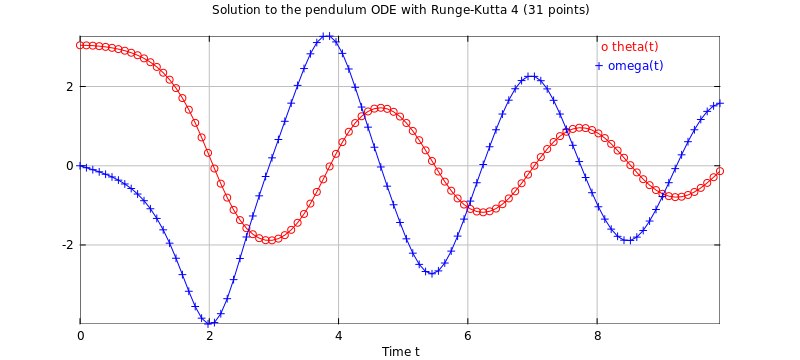

- : unit = ()


In [157]:
let vp = A.init ~w:800. ~h:360. ["jupyter"] in
A.Axes.box vp ;
A.Viewport.xlabel vp "Time t";
A.Viewport.title vp "Solution to the pendulum ODE with Runge-Kutta 4 (31 points)";
A.set_color vp A.Color.red ;
A.Viewport.text vp 8.5 3. "o theta(t)" ;
A.Array.xy ~style:(`Linesmarkers "o") vp t (column sol 0);
A.set_color vp A.Color.blue ;
A.Viewport.text vp 8.5 2.5 "+ omega(t)" ;
A.Array.xy vp ~style:(`Linesmarkers "+") t (column sol 1);
A.close vp;;

In [109]:
let t = linspace 0. 10. 101 ;;
let sol = rungekutta4 f_pend y0 t ;;

val t : float array =
  [|0.; 0.0990099009900990146; 0.198019801980198029; 0.297029702970297071;
    0.396039603960396058; 0.495049504950495045; 0.594059405940594143;
    0.69306930693069313; 0.792079207920792117; 0.891089108910891103;
    0.99009900990099009; 1.08910891089108919; 1.18811881188118829;
    1.28712871287128716; 1.38613861386138626; 1.48514851485148514;
    1.58415841584158423; 1.68316831683168333; 1.78217821782178221;
    1.8811881188118813; 1.98019801980198018; 2.07920792079207928;
    2.17821782178217838; 2.27722772277227747; 2.37623762376237657;
    2.47524752475247523; 2.57425742574257432; 2.67326732673267342;
    2.77227722772277252; 2.87128712871287162; 2.97029702970297027;
    3.06930693069306937; 3.16831683168316847; 3.26732673267326756;
    3.36633663366336666; 3.46534653465346532; 3.56435643564356441;
    3.66336633663366351; 3.76237623762376261; 3.86138613861386171;
    3.96039603960396036; 4.05940594059405946; 4.15841584158415856;
    4.25742574257425765; 4.3

val sol : float array array =
  [|[|3.04156; 0.|]; [|3.0391226684992545; -0.0492285629019174747|];
    [|3.03177276128229733; -0.0996338062721686679|];
    [|3.01927516015746411; -0.153620003759229684|];
    [|3.00115241209564187; -0.213696393492316|];
    [|2.9766689247853475; -0.282586378652772197|];
    [|2.94480437110224091; -0.363336300206605733|];
    [|2.90421640674631698; -0.459421802365044596|];
    [|2.85319326842347198; -0.574843794764229199|];
    [|2.78959810389226659; -0.714194965104298696|];
    [|2.71080965865368428; -0.882657987552806|];
    [|2.61366933385879374; -1.0858624704672728|];
    [|2.49445437940516; -1.32947272354123558|];
    [|2.34891337747415152; -1.61829970140246937|];
    [|2.17242504413163218; -1.95464379348485062|];
    [|1.96037272241410943; -2.33555053709422911|];
    [|1.70885073221755923; -2.74888146198779859|];
    [|1.41579566533549261; -3.16888687934279778|];
    [|1.08249517159997977; -3.55354957515189|];
    [|0.715109711947466087; -3.8477037

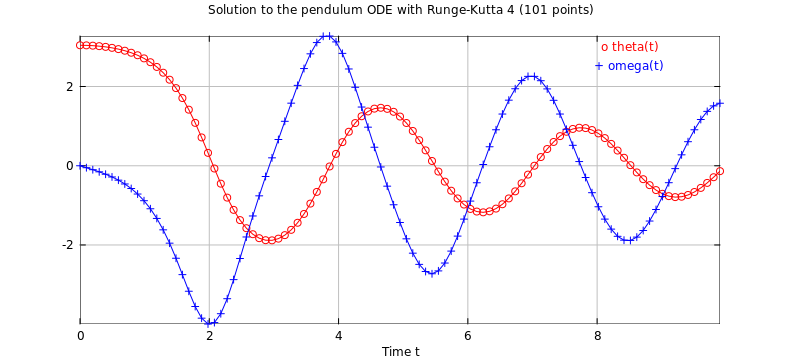

- : unit = ()


In [158]:
let vp = A.init ~w:800. ~h:360. ["jupyter"] in
A.Axes.box vp ;
A.Viewport.xlabel vp "Time t";
A.Viewport.title vp "Solution to the pendulum ODE with Runge-Kutta 4 (101 points)";
A.set_color vp A.Color.red ;
A.Viewport.text vp 8.5 3. "o theta(t)" ;
A.Array.xy ~style:(`Linesmarkers "o") vp t (column sol 0);
A.set_color vp A.Color.blue ;
A.Viewport.text vp 8.5 2.5 "+ omega(t)" ;
A.Array.xy vp ~style:(`Linesmarkers "+") t (column sol 1);
A.close vp;;

----
## Comparisons

In [120]:
let methods = [|rungekutta1; rungekutta2; rungekutta4|] ;;
let names = [|"Runge-Kutta 1"; "Runge-Kutta 2"; "Runge-Kutta 4"|] ;;
let markers = [|"o"; "s"; ">"|] ;;
let colors = [|A.Color.red; A.Color.blue; A.Color.green|] ;;

val methods :
  ((float array -> float -> float array) ->
   float array -> float array -> float array array)
  array = [|<fun>; <fun>; <fun>|]


val names : string array =
  [|"Runge-Kutta 1"; "Runge-Kutta 2"; "Runge-Kutta 4"|]


val markers : string array = [|"o"; "s"; ">"|]


val colors : A.Color.t array = [|<abstr>; <abstr>; <abstr>|]


In [159]:
let test_1 ?(n=101) () =
    let t = linspace 0. 10. n in
    let vp = A.init ~w:800. ~h:360. ["jupyter"] in
    A.Axes.box vp ;
    A.Viewport.xlabel vp "Time t";
    A.Viewport.title vp (Format.sprintf "Solution to the pendulum ODE with different methods (%i points)" n);
    for i = 0 to (Array.length methods) - 1 do
        let sol = methods.(i) f_pend y0 t in
        A.set_color vp colors.(i);
        A.Viewport.text vp 6.5 (2. -. 2.*.(float_of_int i)) (Format.sprintf "%s %s" markers.(i) names.(i)) ;
        A.Array.xy ~style:(`Linesmarkers markers.(i)) vp t (column sol 0);
    done;
    A.close vp;
;;

val test_1 : ?n:int -> unit -> unit = <fun>


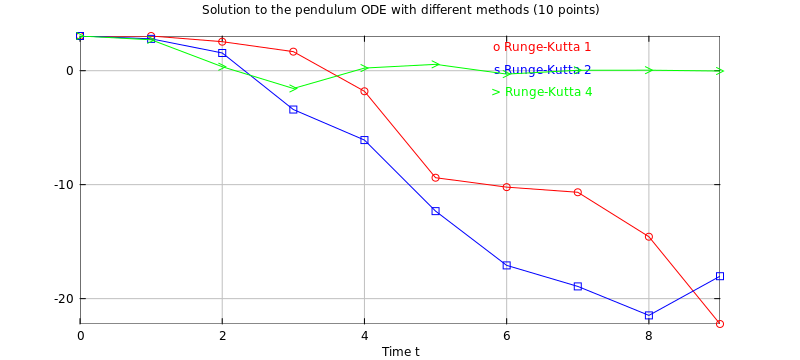

- : unit = ()


In [160]:
test_1 ~n:10 ();;

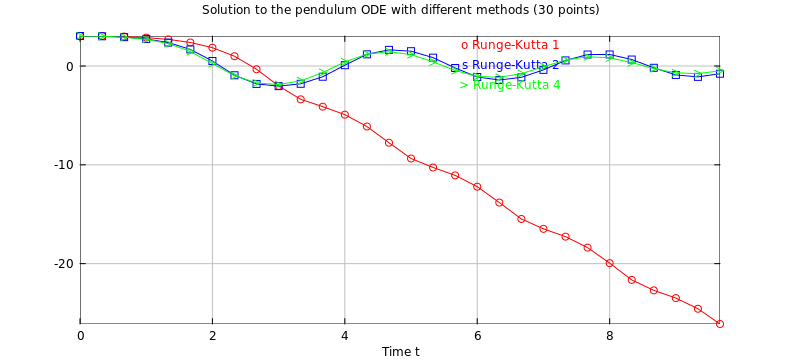

- : unit = ()


In [161]:
test_1 ~n:30 ();;

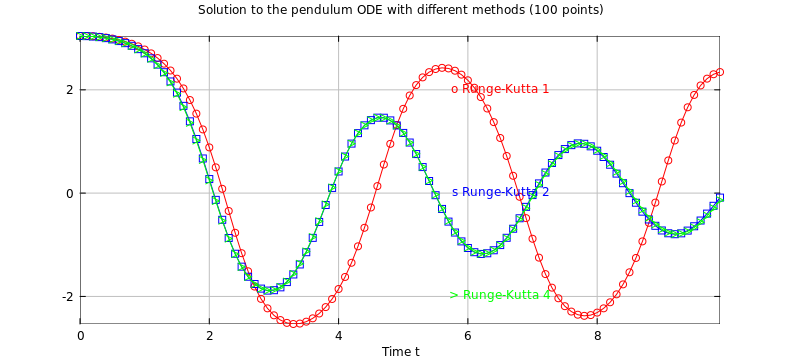

- : unit = ()


In [162]:
test_1 ~n:100 ();;

## Conclusion

> *That's it for today, folks!* See my other notebooks, [available on GitHub](https://github.com/Naereen/notebooks/).